In [36]:
import argparse
import os, shutil
import sys
from tensorflow.keras.utils import disable_interactive_logging
import time

training_ratio=0.7
look_back=1
batch_size=32


start_time = time.time()
# to supress the output of keras-tuner
disable_interactive_logging()


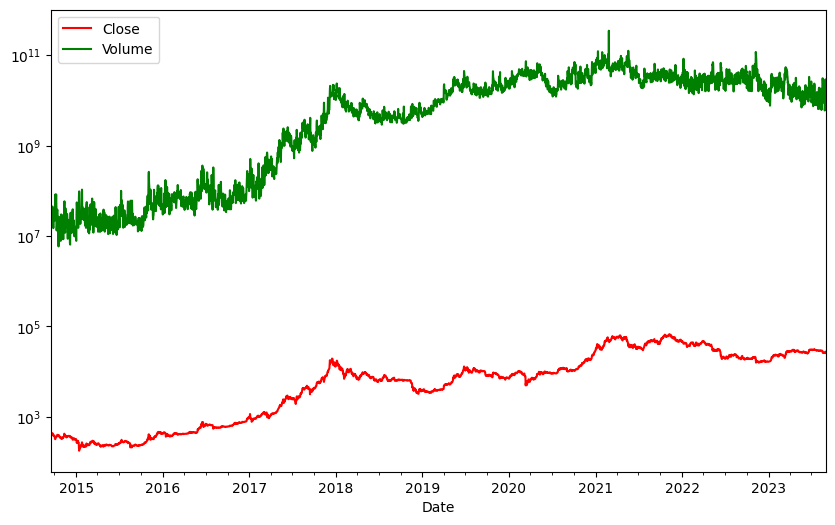

In [37]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# load a dataset
data_file = "../Data/BTC-all.arff"

# Load arff file
data, meta = arff.loadarff(data_file)
data_df = pd.DataFrame(data)



# Convert to pandas DataFrame
#data_df = pd.read_csv('bitcoin_hist.csv')
#data_df["Date"] =  pd.to_datetime(data_df["Date"], format="%m/%d/%Y")

data_df.plot(x='Date', y=['Close', 'Volume'], style=['r-', 'g-'], figsize=(10, 6))  # for stock

# define the date format
date_form = mdates.DateFormatter('%Y')

# set the x-axis major locator to every even year
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=1))
ax.xaxis.set_major_formatter(date_form)
ax.set_yscale("log")

plt.show()

In [38]:
data_df["Date"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 3271 entries, 0 to 3270
Series name: Date
Non-Null Count  Dtype         
--------------  -----         
3271 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 25.7 KB


In [39]:
close_index = data_df.columns.get_loc('Close')
dataset = data_df.iloc[:, close_index:close_index+1].values  # numpy array
dataset = dataset.astype('float32')


In [40]:
from keras.callbacks import EarlyStopping
# define early stopping
early_stopping5 = EarlyStopping(monitor='val_loss', patience=5, verbose=0)

In [41]:
from tensorflow.keras.callbacks import Callback

class StopAtThreshold(Callback):
    def __init__(self, monitor='loss', threshold=0.01):
        super(StopAtThreshold, self).__init__()
        self.monitor = monitor
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is not None and current < self.threshold:
            self.model.stop_training = True


In [42]:
# create an instance of our custom callback
stop_at_threshold = StopAtThreshold(monitor='val_loss', threshold=0.015)

In [43]:
import os
import random
import numpy as np
import tensorflow as tf

def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    # If you are using CUDA, uncomment the following 2 lines
    # os.environ['TF_DETERMINISTIC_OPS'] = '1'
    # os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

set_seeds(1234)

In [44]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [45]:
def plotTrainingNTest(trainY, trainPredict, testY, testPredict, title=''):
    fig, ax = plt.subplots(2,figsize=(15, 10))
    n_records = len(data_df)
    date_index = data_df.columns.get_loc('Date')

    boundary = round(n_records*training_ratio)
    train_dates=data_df.iloc[look_back:boundary, date_index].tolist()
    colors = ['rs-', 'bo-']  # r: red, b: blue, g: green, y: yellow, ^: triangle

    # plot each output
    ax[0].plot_date(train_dates, trainY.tolist(), colors[0])
    ax[0].plot_date(train_dates, trainPredict.tolist(), colors[1])
    # define the date format
    date_form = mdates.DateFormatter('%Y')

    # set the x-axis major locator to every even year
    ax[0].xaxis.set_major_locator(mdates.YearLocator(base=1))

    # Convert these dates to numeric format for matplotlib
    #dates_numeric = mdates.date2num(train_dates[::5])

    # Set these as the x-ticks, only need for Month or DayLocator
    # ax[0].set_xticks(dates_numeric)

    #ax.set_yticks(range(310, 410, 5))
    # set the x-axis major formatter to the date format
    ax[0].xaxis.set_major_formatter(date_form)
    legends=['actual', 'predicted']
    #legends.extend([f'passenger_numbers_{step}-steps-ahead' for step in steps_ahead])
    ax[0].legend(legends, ncol=2, loc=4)
    ax[0].grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    ax[0].set_title(f"{title} Predictions on Training data")

    test_dates=data_df.iloc[boundary:, date_index].tolist()
    ax[1].plot_date(test_dates, testY.tolist(), colors[0])
    ax[1].plot_date(test_dates, testPredict.tolist(), colors[1])

    # set the x-axis major locator to every even year
    ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    # Convert these dates to numeric format for matplotlib
    #dates_numeric = mdates.date2num(test_dates[::5])

    # Set these as the x-ticks
    #ax[1].set_xticks(dates_numeric)
    date_form = mdates.DateFormatter('%m-%Y')
    #ax.set_yticks(range(310, 410, 5))
    # set the x-axis major formatter to the date format
    ax[1].xaxis.set_major_formatter(date_form)
    legends=['actual', 'predicted']
    #legends.extend([f'passenger_numbers_{step}-steps-ahead' for step in steps_ahead])
    ax[1].legend(legends, ncol=2, loc=4)
    ax[1].grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    ax[1].set_title(f"{title} Predictions on Test data")
    plt.subplots_adjust(hspace=0.4)
    plt.show()


In [46]:
from pymannkendall import seasonal_test

result = seasonal_test(data_df['Close'])
print(result)
trend, h, p, z, Tau, s, var_s, slope, intercept = result
import re
params=re.split(r'\s*,\s', "trend, h, p, z, Tau, s, var_s, slope, intercept")
for pr in params:
    print(f'{pr}={eval(pr)}')

Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=63.42762554400573, Tau=0.7440969345484673, s=330510.0, var_s=27152490.666666664, slope=102.85675554316177, intercept=-6112.143098755791)
trend=increasing
h=True
p=0.0
z=63.42762554400573
Tau=0.7440969345484673
s=330510.0
var_s=27152490.666666664
slope=102.85675554316177
intercept=-6112.143098755791


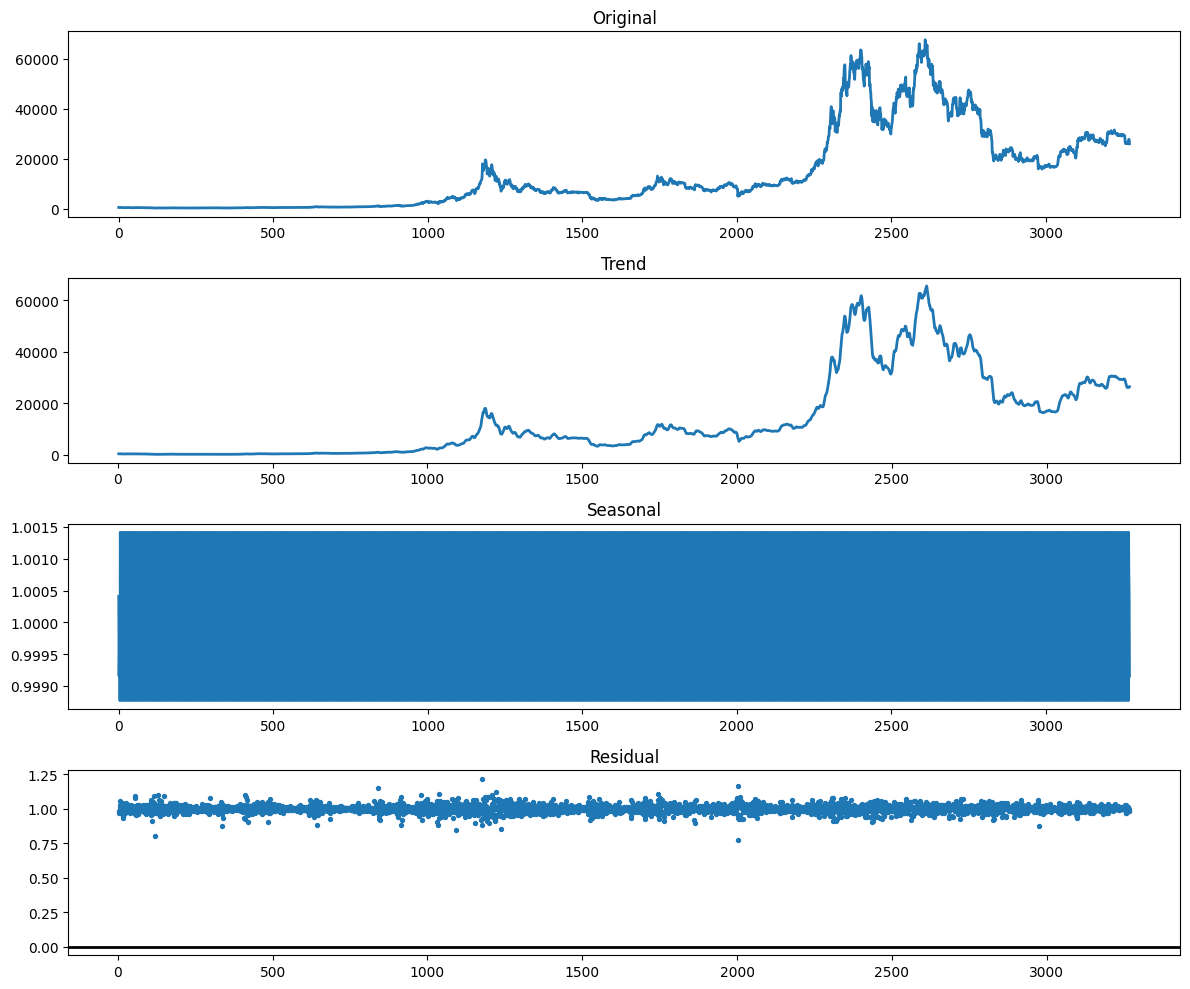

In [47]:

from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
# google stock price is daily, so
seasonal_period=7
df = data_df.copy()
#df['Close'] = np.log(df['Close'])
# Decompose the 'Close' column #multiplicative or additive
decomposition = seasonal_decompose(df['Close'], model='multiplicative', period=seasonal_period)

# Extract the components
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))  # Set the figure size

# Plot the original series
axes[0].plot(df['Close'], linewidth=2)  # Set the line width (point size)
axes[0].set_title('Original')

# Plot the trend component
axes[1].plot(trend, linewidth=2)
axes[1].set_title('Trend')

# Plot the seasonal component
axes[2].plot(seasonal, linewidth=2)
axes[2].set_title('Seasonal')

# Plot the residual component
axes[3].scatter(residual.index, residual, s=8)
axes[3].axhline(y=0, color='k', linestyle='-', linewidth=2)  # Horizontal line at y=0
axes[3].set_title('Residual')

plt.tight_layout()
plt.show()

In [48]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# because it's multiplicative, so apply np.log
dataset = np.log(dataset)

# Initialize a scaler for the dataset
#scaler = MinMaxScaler(feature_range=(0, 1))
# Z-score normalization is useful when the data has outliers or when the distribution of the data is not known. 
scaler = StandardScaler() 

# Fit and transform the data to the scaler
# Split into train and test sets
from sklearn.model_selection import train_test_split
training_ratio = training_ratio
train_data, test_data = train_test_split(dataset, train_size=training_ratio, shuffle=False)

# Fit the scaler to the training data and transform the training data
train = scaler.fit_transform(train_data)

# Use the same scaler to transform the test data
test = scaler.transform(test_data)
print(train.shape, test.shape)### Using Multiple Layer Perceptron

(2289, 1) (982, 1)


In [49]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import regularizers

# reshape dataset
look_back = look_back
trainX, trainY = create_dataset(train, look_back)
test_data_with_look_back = np.concatenate((train[-look_back:], test))

# Create testing data, starting with the end of the training data
testX, testY = create_dataset(test_data_with_look_back, look_back)

In [50]:
from keras.layers import Conv1D, LSTM, Lambda, Dropout
from keras_tuner import RandomSearch
from keras.optimizers import Adam
from sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping

def build_model(hp):
    model = Sequential()

    # Input layer
    model.add(LSTM(units=hp.Int('input_units',min_value=100,max_value=256,step=16),
                  return_sequences=True,input_shape=(look_back, 1)))
    
    
    """    
    model.add(Dropout(rate=hp.Float(
                'dropout',
                min_value=0.0,
                max_value=0.5,
                #default=0.25,
                step=0.05)))

    # Hidden layers
    num_layers = hp.Int('num_layers', 1, 5)

    for i in range(num_layers):
        if i < num_layers - 1:  # Not the last layer
            model.add(LSTM(units=hp.Int(f'lstm_units_{num_layers}{i}', 
                                        min_value=100, max_value=512, step=32), 
                           return_sequences=True))
        else:  # The last layer
            model.add(LSTM(units=hp.Int(f'lstm_units_{num_layers}{i}', 
                                        min_value=100, max_value=512, step=32), 
                           return_sequences=False))
        model.add(Dropout(rate=hp.Float(f'dropout_{num_layers}{i}', 
                                        min_value=0.0, max_value=0.5, 
                                        #default=0.25, 
                                        step=0.05)))
    """
    # Output layer
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3])),
                  loss='mean_absolute_error')
    return model

# create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=5)

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    project_name='bitcoin')

# define early stopping
early_stopping15 = EarlyStopping(monitor='val_loss', patience=15, verbose=0)
# create an instance of our custom callback
stop_at_threshold = StopAtThreshold(monitor='val_loss', threshold=0.01)
# perform hyperparameter tuning with time series cross-validation
for train_index, val_index in tscv.split(trainX):
    X_train, X_val = trainX[train_index], trainX[val_index]
    y_train, y_val = trainY[train_index], trainY[val_index]
    tuner.search(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        callbacks=[early_stopping15]
        #callbacks=[stop_at_threshold]
    )

# tuner.search_space_summary()
# get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# get the best trial
best_trial = tuner.oracle.get_best_trials()[0]



# get the score of the best trial
best_score = best_trial.score

# print the score of the best trial
print(f"Best score: {best_score}")

# print the values of the best hyperparameters
for hp in best_hp.values:
    print(f"{hp}: {best_hp.get(hp)}")

#!pip install keras-self-attention
#!pip install keras-self-attention --upgrade

from keras.callbacks import EarlyStopping
# define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=0)
# create an instance of our custom callback
stop_at_threshold = StopAtThreshold(monitor='val_loss', threshold=0.01)



from sklearn.model_selection import train_test_split
from keras_tuner import HyperParameters
ntrainX, valX, ntrainY, valY = train_test_split(trainX, trainY, test_size=0.1, shuffle=False)

#start_time = time.time()

# create a new HyperParameters object
new_hp = HyperParameters()

# set the hyperparameters to the desired values
new_hp.Fixed('input_units', 196)
new_hp.Fixed('learning_rate', 0.001)

# build a new model with the specified hyperparameters
model = build_model(new_hp)

# build the best model
# model = build_model(best_hp)

# fit the model with early stopping
history = model.fit(
    ntrainX, ntrainY,
    validation_data=(valX, valY),
    epochs=1000,
    batch_size=batch_size, 
    verbose=0,
    callbacks=[early_stopping15]
    #callbacks=[stop_at_threshold]
)

# generate predictions for training
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

INFO:tensorflow:Reloading Tuner from .\bitcoin\tuner0.json


INFO:tensorflow:Reloading Tuner from .\bitcoin\tuner0.json


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Best score: 0.037774731094638504
input_units: 228
learning_rate: 0.01


In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math


# Inverse transform the predictions to original scale
trainPredict_orig = np.exp(scaler.inverse_transform(trainPredict))
trainY_orig = np.exp(scaler.inverse_transform([trainY]))
mse = mean_squared_error(trainY_orig[0], trainPredict_orig[:,0])
mae = mean_absolute_error(trainY_orig[0], trainPredict_orig[:,0])
print(f'train MSE: {mse:.4f}, RMSE: {math.sqrt(mse):.4f}, MAE: {mae:.4f}')

testPredict_orig = np.exp(scaler.inverse_transform(testPredict))
testY_orig = np.exp(scaler.inverse_transform([testY]))

# Now you can calculate your evaluation metrics on the original scale
mse = mean_squared_error(testY_orig[0], testPredict_orig[:,0])
mae = mean_absolute_error(testY_orig[0], testPredict_orig[:,0])
print(f'test MSE: {mse:.4f}, RMSE: {math.sqrt(mse):.4f}, MAE: {mae:.4f}')
end_time = time.time()
elapse = end_time-start_time
print(f'Total time: {elapse//60} minutes, {elapse%60:.4f} seconds.')
# plotTrainingNTest(trainY_orig[0], trainPredict_orig[:,0], testY_orig[0], testPredict_orig[:,0], 'LSTM')

train MSE: 123107.8297, RMSE: 350.8673, MAE: 160.8946
test MSE: 21837804.8126, RMSE: 4673.0937, MAE: 3723.1607
Total time: 0.0 minutes, 7.6954 seconds.
